### Trying to fix the sky
#### Import Statements & WandB

In [1]:
# WandB setup first
import sys
import os
import wandb
import torch
import warnings
from asset.utils import *
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
from asset.transforms import DisparityTransformCompose, DisparityTransform, RandomCrop, Interpolate, CutMix
from asset.datasets import DisparityDataset
from asset.criterion import NonZeroWrapper, IntermediateSupervisionWrapper, PE
from asset.model import BaselineModel, CustomModel
from asset.trainer import TrainerKitti

if not sys.warnoptions:
    warnings.simplefilter("ignore", category=UserWarning)

            
#os.environ['WANDB_MODE'] = 'dryrun' #uncomment to prevent wandb logging - 'offline mode'

hyperparameter_defaults = dict(
    encoder_depth= 4,
    encoder_backbone='efficientnet-b3', #mobilenet_v2
    height_train=256,
    width_train=512,
    height_valid=368,
    width_valid=1248,
    n_epochs=1000,
    patience=12,
    batch_size_train=8,
    batch_size_valid=1,
    lr=1e-3,
    lr_decay=0.992,
    pretrained=True,
    augment_data=False
)

wandb.init(config=hyperparameter_defaults, project="CudaLab_SS21_Train")
print("Python Version:", sys.version)
print("PyTorch Version:", torch.__version__)
print("Cuda Version:", torch.version.cuda)
print("CUDNN Version:", torch.backends.cudnn.version())

config=wandb.config

pretrained_title = config.encoder_backbone + f'_encoder_depth_{config.encoder_depth}'+'_pretrained'
pretrain_str = '_pretrain' if config.pretrained else '_nopretrain'
augment_str = '_augment' if config.augment_data else '_noaugment'
experiment_title = config.encoder_backbone + pretrain_str + augment_str +'_fix_sky'
print('Experiment title:', experiment_title)
pretty_print(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jannogga (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Python Version: 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
PyTorch Version: 1.8.1
Cuda Version: 11.1
CUDNN Version: 8005
Experiment title: efficientnet-b3_pretrain_noaugment_fix_sky
  encoder_depth                4
  encoder_backbone             efficientnet-b3
  height_train                 256
  width_train                  512
  height_valid                 368
  width_valid                  1248
  n_epochs                     1000
  patience                     12
  batch_size_train             8
  batch_size_valid             1
  lr                           0.001
  lr_decay                     0.992
  pretrained                   True
  augment_data                 False


#### Dataset and Dataloader Creation

In [2]:
class OffsetZero(object):
    """Offset zero values in the disparity mask."""

    def __init__(self, offset=42):
        self.offset=offset

    def __call__(self, imgs, disparity):
        img_left, img_right = imgs

        mask = disparity < 1e-12
        disparity[mask] -= self.offset

        return (img_left, img_right), disparity

In [3]:
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = DisparityTransformCompose([DisparityTransform(transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05), apply_to_disparity=False),
                                       DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False),
                                       OffsetZero(offset=42),
                                       RandomCrop(output_size=(config.height_train,config.width_train))])


# transform_large = DisparityTransformCompose([DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False),
#                                        RandomCrop(output_size=(352,1216))])

transform_large = DisparityTransformCompose([DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False)])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(MEAN, STD)],
   std= [1/s for s in STD]
)


kitti_dataset = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform)
kitti_dataset_large = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform_large)
print('Number of samples in the KITTI dataset:', len(kitti_dataset))

train_share = 0.75
N_samples = len(kitti_dataset)
#N_samples = 40 ### REMOVE THIS LINE AFTER DEBUGGING!!!
indices = list(range(N_samples))
split = int(np.ceil(train_share * N_samples))
np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[:split], indices[split:]
print('Number of training : validation samples -', len(train_idx), ':', len(valid_idx))
trainset = torch.utils.data.Subset(kitti_dataset, train_idx)
validset = torch.utils.data.Subset(kitti_dataset_large, valid_idx)

if config.augment_data:
    transform = DisparityTransformCompose([transform,
                                       CutMix(trainset)])
    kitti_dataset = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform)
    trainset = torch.utils.data.Subset(kitti_dataset, train_idx)
    






transform_monkaa = DisparityTransformCompose([DisparityTransform(transforms.Normalize(mean_imagenet, std_imagenet), apply_to_disparity=False),
                                       RandomCrop(output_size=(config.height_train,config.width_train))])


monkaa_dataset = DisparityDataset(get_left_frames_monkaa(), left_to_right_monkaa, left_to_disparity_monkaa, load_image_sceneflow, load_disparity_sceneflow, transform_monkaa)



monkaa_dataset = torch.utils.data.Subset(monkaa_dataset, np.array([4,10,29,49,32,17,39,30,1002,1022,1052,1041,2370,2390,2373,2371]))
concat_dataset = ConcatDataset([trainset, monkaa_dataset])

trainloader = torch.utils.data.DataLoader(concat_dataset, batch_size=config.batch_size_train, shuffle=True, num_workers=10)
validloader = torch.utils.data.DataLoader(validset, batch_size=config.batch_size_valid, shuffle=False, num_workers=10)

print('Number of samples in the Monkaa dataset:', len(monkaa_dataset))
print('Number of samples in the concatenated training dataset:', len(concat_dataset))

Number of samples in the KITTI dataset: 200
Number of training : validation samples - 150 : 50
Number of samples in the Monkaa dataset: 16
Number of samples in the concatenated training dataset: 166


#### Show Data Samples

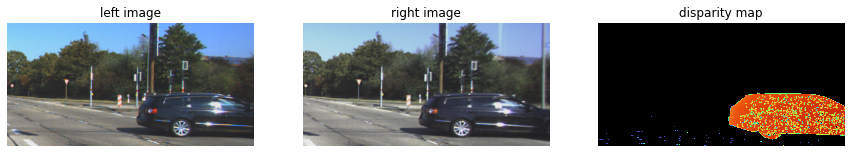

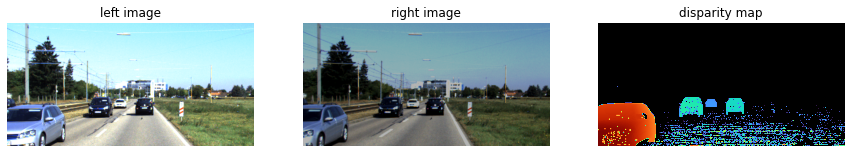

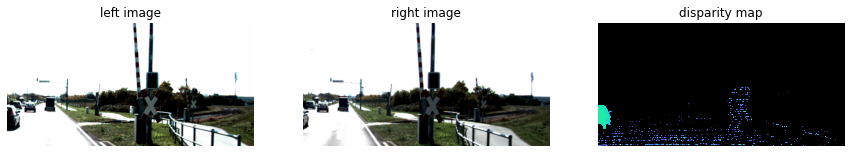

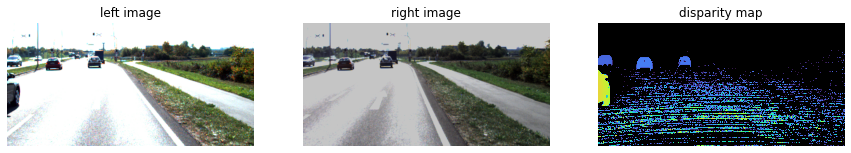

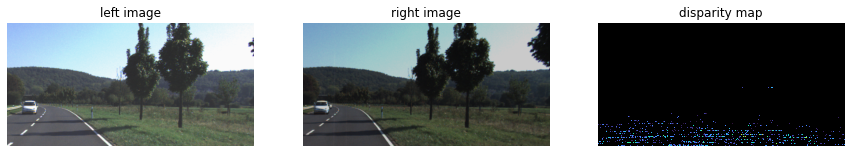

In [4]:
rand_idx = np.random.choice(np.arange(len(concat_dataset)), size=5, replace=False)
#rand_idx = [1871, 12612, 31972]
for i in rand_idx:
    (img_left, img_right), img_disparity = concat_dataset[i]
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    show_image(inv_normalize(img_left), ax=axes[0], title='left image')
    
    show_image(inv_normalize(img_right), ax=axes[1], title='right image')
    
    show_disparity(img_disparity, ax=axes[2], title='disparity map')

    plt.show()

#### Losses

In [5]:
criterion_smoothl1 = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
wrapped_criterion_smoothl1 = NonZeroWrapper(torch.nn.SmoothL1Loss(reduction='none', beta=1.0), eps=-1, max_disp=192)
wrapped_criterion_smoothl1 = IntermediateSupervisionWrapper(wrapped_criterion_smoothl1)
wrapped_criterion_1PE = NonZeroWrapper(PE(reduction='none', threshold=1), eps=-1)
wrapped_criterion_3PE = NonZeroWrapper(PE(reduction='none'), eps=-1)
wrapped_criterion_5PE = NonZeroWrapper(PE(reduction='none', threshold=5), eps=-1)
metrics = {
  "1PE": wrapped_criterion_1PE,
  "3PE": wrapped_criterion_3PE,
  "5PE": wrapped_criterion_5PE
}

#### Models

In [6]:
model_custom = CustomModel(encoder_depth=config.encoder_depth, backbone=config.encoder_backbone)

n_params = count_parameters(model_custom)
wandb.run.summary['Parameter Number'] = n_params
print(f'The model has {n_params} trainable parameters.')

The model has 16687768 trainable parameters.


#### Trainer

In [7]:
if config.pretrained:
    print('Loading pretrained model!')
    title = pretrained_title
    pretrain_loader = TrainerKitti(model_custom, wrapped_criterion_smoothl1, trainloader, validloader, eval_metrics=metrics, es_mode='min', description=title, patience=32, lr=config.lr, n_epochs=config.n_epochs, lr_decay=config.lr_decay, size_y=config.height_valid, size_x=config.width_valid)
    pretrain_loader.load_model()
    model_custom = pretrain_loader.model

Loading pretrained model!


In [8]:
title = experiment_title
custom_trainer = TrainerKitti(model_custom, wrapped_criterion_smoothl1, trainloader, validloader, eval_metrics=metrics, es_mode='min', description=title, patience=config.patience, lr=config.lr, n_epochs=config.n_epochs, lr_decay=config.lr_decay, size_y=config.height_valid, size_x=config.width_valid)
custom_trainer.fit()

  1%|          | 12/1000 [21:41<29:46:27, 108.49s/it, V of [50]=50]

Early stopping triggered!


In [9]:
wandb.save('models/'+experiment_title+'_best.pt')
wandb.save('trainer_logs/'+experiment_title+'.npy')

['/home/jannogga/Repos/Vision_Systems_Lab/Project_Solution/wandb/run-20210930_183955-1d609o3e/files/trainer_logs/efficientnet-b3_pretrain_noaugment_fix_sky.npy']